## 1.Load S&P data

In [1]:
import Loader as loader
from StockMarketInvestor import StockMarketInvestor

In [2]:
sp_comp = loader.get_sp_index()
print("S&P Companies")
sp_comp.head()

S&P Companies


,Company,Symbol,Weight,Price,Chg
0,Apple Inc.,AAPL,6.878571,167.80,0.40
1,Microsoft Corporation,MSFT,5.669560,286.89,1.59
2,Amazon.com Inc.,AMZN,3.668142,3092.00,-70.31
3,Tesla Inc,TSLA,2.281229,1028.40,0.25
4,Alphabet Inc. Class A,GOOGL,2.072692,2571.95,-28.23


In [3]:
#Peek at data
sp_hist = loader.get_ticker_historical(list(sp_comp["Symbol"]))
print("S&P Historical Data")
sp_hist[["AMZN","TSLA", "AAPL", "NFLX"]].tail()

S&P Historical Data


,AMZN,TSLA,AAPL,NFLX
Date,,,,
2022-03-24,3272.989990,1013.919983,174.070007,375.709991
2022-03-25,3295.469971,1010.640015,174.720001,373.850006
2022-03-28,3379.810059,1091.839966,175.600006,378.510010
2022-03-29,3386.300049,1099.569946,178.960007,391.820007
2022-03-30,3326.020020,1093.989990,177.770004,381.470001


In [4]:
print("S&P Historical Data statistical description")
sm_list = ["AMZN","TSLA", "AAPL", "NFLX"]
sp_hist_short = sp_hist[sm_list]
sp_hist_short.describe()

S&P Historical Data statistical description


,AMZN,TSLA,AAPL,NFLX
count,513.000000,513.000000,513.000000,513.000000
mean,3131.497037,623.689936,128.451540,507.627290
std,370.562331,284.574884,29.307192,76.135233
min,1846.089966,85.505997,56.092499,331.010010
25%,3057.159912,415.089996,115.050003,476.260010
50%,3217.010010,663.690002,129.639999,508.820007
75%,3355.729980,818.320007,148.759995,546.989990
max,3731.409912,1229.910034,182.009995,691.690002


## 2.Visualize Price and Monthly returns

<AxesSubplot:xlabel='Date'>

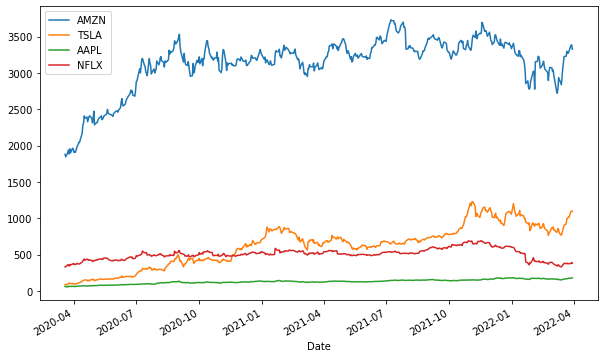

In [5]:
sp_hist_short.plot(figsize=(10,6))

<AxesSubplot:xlabel='Date'>

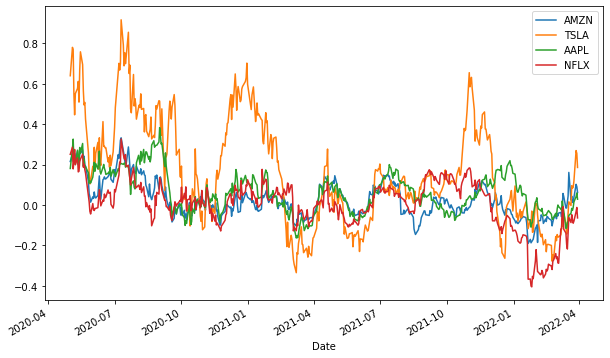

In [6]:
sp_hist_short.pct_change(30).dropna().plot(figsize=(10, 6))

<AxesSubplot:>

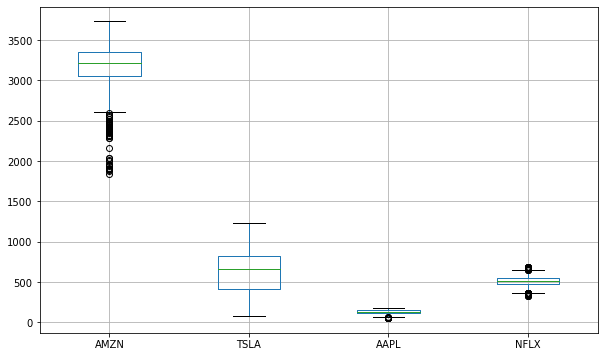

In [7]:
sp_hist_short.boxplot(figsize=(10, 6))

## 3. Run Stock Market Investor

### a) Run without constrains

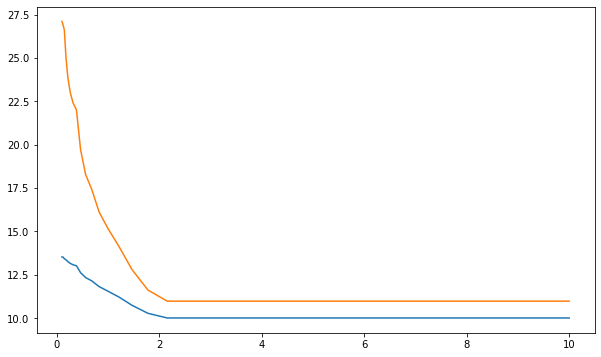

Optimal gamma @ 2.1544346900318834


In [8]:
import warnings
warnings.filterwarnings("ignore")

sm = StockMarketInvestor(sp_hist, 0.1)
sm.train()

In [9]:
ret = sm.optimize()

Optimal portfolio
----------------------
 Investment in BBWI : 6% of the portfolio
 Investment in NVDA : 6% of the portfolio
 Investment in ENPH : 3% of the portfolio
 Investment in FCX : 25% of the portfolio
 Investment in DVN : 20% of the portfolio
 Investment in MRNA : 4% of the portfolio
 Investment in MOS : 25% of the portfolio
 Investment in CZR : 4% of the portfolio
 Investment in TSLA : 9% of the portfolio
----------------------
Exp ret = 10.0%
Expected risk    = 10.97%


### b) Run with constrains include

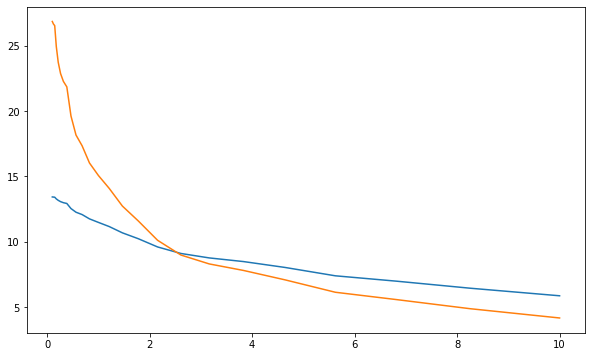

Optimal gamma @ 2.1544346900318834


In [10]:
sm = StockMarketInvestor(sp_hist, 0.05, include=['AAPL'])
sm.train()

In [11]:
ret = sm.optimize()

Optimal portfolio
----------------------
 Investment in BBWI : 4% of the portfolio
 Investment in NVDA : 11% of the portfolio
 Investment in ENPH : 3% of the portfolio
 Investment in FCX : 23% of the portfolio
 Investment in DVN : 18% of the portfolio
 Investment in MRNA : 4% of the portfolio
 Investment in MOS : 28% of the portfolio
 Investment in CZR : 2% of the portfolio
 Investment in TSLA : 5% of the portfolio
 Investment in AAPL : 1% of the portfolio
----------------------
Exp ret = 9.6%
Expected risk    = 10.11%


### b) Run with constrains include and exclude

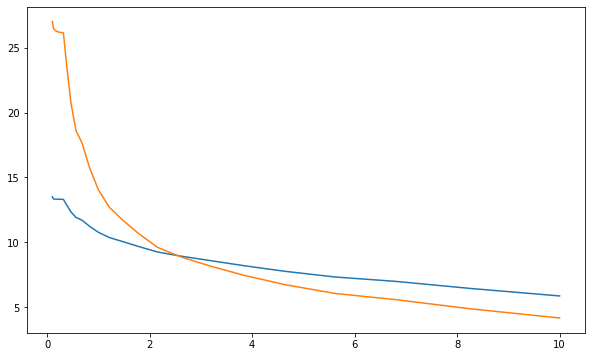

Optimal gamma @ 2.1544346900318834


In [12]:
sm = StockMarketInvestor(sp_hist, 0.05, include=['AAPL'], exclude=['TSLA','FCX'])
sm.train()

In [13]:
ret = sm.optimize()
ret = ret.merge(sp_comp, left_on='Symbol', right_on='Symbol')

Optimal portfolio
----------------------
 Investment in BBWI : 6% of the portfolio
 Investment in NVDA : 14% of the portfolio
 Investment in ENPH : 7% of the portfolio
 Investment in DVN : 23% of the portfolio
 Investment in MRNA : 7% of the portfolio
 Investment in MOS : 42% of the portfolio
 Investment in CZR : 2% of the portfolio
 Investment in AAPL : 1% of the portfolio
----------------------
Exp ret = 9.27%
Expected risk    = 9.62%


In [14]:
ret = ret.sort_values(by="InvestmentPercentage", ascending=False)

## USE LSTM To predict stock ticker, Can we make selections at individual level

In [15]:
#choose top 4 stocks for prediction
sel_lst = list(ret["Symbol"][:5])
print(f"Choosen stocks: {sel_lst}")
sel_hist = sp_hist[sel_lst]

Choosen stocks: ['MOS', 'DVN', 'NVDA', 'ENPH', 'MRNA']


In [53]:
sp_comp[sp_comp["Symbol"].isin(sel_hist)]

,Company,Symbol,Weight,Price,Chg
7,NVIDIA Corporation,NVDA,1.470847,216.23,-5.76
148,Moderna Inc.,MRNA,0.142583,150.60,-2.12
204,Devon Energy Corporation,DVN,0.104791,64.80,1.80
265,Mosaic Company,MOS,0.076447,75.51,-2.47
286,Enphase Energy Inc.,ENPH,0.069573,179.09,-16.51


In [54]:
mos = sel_hist["NVDA"].reset_index().drop(columns=["Date"])

In [55]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
mos = scaler.fit_transform(np.array(mos).reshape(-1,1))

In [89]:
#split into training and test data splits
xtrs = int(len(mos)*0.80)
xtss = len(mos) - xtrs
train, test = mos[0:xtrs, :],  mos[xtrs:, :1]

In [93]:
print(train.shape,test.shape)

(410, 1) (103, 1)


In [94]:
def create_features_targets(ds, time_step=1):
    X, y= [], []
    tf = len(ds)-time_step-1
    for i in range(tf):
        X.append(ds[i:(i+time_step),0])
        y.append(ds[(i+time_step),0])    
    return np.array(X), np.array(y)

In [96]:
time_step = 60
X_train, y_train = create_features_targets(train, time_step)
X_test, ytest = create_features_targets(test, time_step)\
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [97]:
print(X_train.shape, y_train.shape, X_test.shape, ytest.shape)

(349, 60, 1) (349,) (42, 60, 1) (42,)


In [98]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [101]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [102]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
6/6 [==============================] - 4s 223ms/step - loss: 0.1072 - val_loss: 0.1082
Epoch 2/100
6/6 [==============================] - 0s 74ms/step - loss: 0.0172 - val_loss: 0.0063
Epoch 3/100
6/6 [==============================] - 0s 78ms/step - loss: 0.0069 - val_loss: 0.0666
Epoch 4/100
6/6 [==============================] - 0s 80ms/step - loss: 0.0089 - val_loss: 0.0205
Epoch 5/100
6/6 [==============================] - 1s 88ms/step - loss: 0.0058 - val_loss: 0.0075
Epoch 6/100
6/6 [==============================] - 0s 83ms/step - loss: 0.0042 - val_loss: 0.0249
Epoch 7/100
6/6 [==============================] - 0s 84ms/step - loss: 0.0038 - val_loss: 0.0106
Epoch 8/100
6/6 [==============================] - 1s 86ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 9/100
6/6 [==============================] - 0s 83ms/step - loss: 0.0019 - val_loss: 0.0068
Epoch 10/100
6/6 [==============================] - 0s 77ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 11/100
6/6 [

6/6 [==============================] - 0s 78ms/step - loss: 6.6716e-04 - val_loss: 0.0076
Epoch 84/100
6/6 [==============================] - 0s 80ms/step - loss: 6.7037e-04 - val_loss: 0.0073
Epoch 85/100
6/6 [==============================] - 0s 81ms/step - loss: 6.9269e-04 - val_loss: 0.0110
Epoch 86/100
6/6 [==============================] - 0s 78ms/step - loss: 6.5824e-04 - val_loss: 0.0084
Epoch 87/100
6/6 [==============================] - 0s 83ms/step - loss: 7.5332e-04 - val_loss: 0.0077
Epoch 88/100
6/6 [==============================] - 1s 85ms/step - loss: 7.4123e-04 - val_loss: 0.0075
Epoch 89/100
6/6 [==============================] - 0s 81ms/step - loss: 6.5618e-04 - val_loss: 0.0077
Epoch 90/100
6/6 [==============================] - 0s 83ms/step - loss: 6.5543e-04 - val_loss: 0.0068
Epoch 91/100
6/6 [==============================] - 0s 84ms/step - loss: 6.4779e-04 - val_loss: 0.0057
Epoch 92/100
6/6 [==============================] - 0s 81ms/step - loss: 7.0904e-04 - 

In [104]:
##Transformback to original form
train_predict=scaler.inverse_transform(model.predict(X_train))
test_predict=scaler.inverse_transform(model.predict(X_test))

In [105]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

156.2410926517359

In [106]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

249.0177486809174

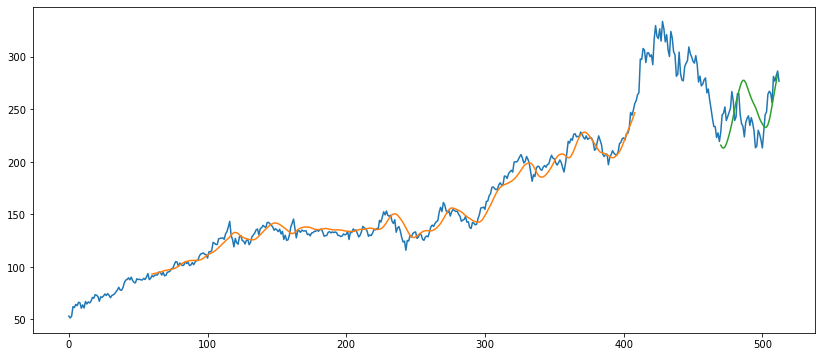

In [110]:
import matplotlib.pyplot as plt
### Plotting 
# shift train predictions for plotting
look_back=60
trainPredictPlot = np.empty_like(mos)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(mos)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(mos)-1, :] = test_predict
# plot baseline and predictions

plt.figure(figsize=(14,6))
plt.plot(scaler.inverse_transform(mos))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()